In [6]:
#import packages
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape, Point
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request, json
import requests
import urllib.parse
import datetime
import pickle

import warnings
warnings.filterwarnings('ignore')

In [11]:
with open('../Outputs/serv_req_compound_score.pickle', 'rb') as f:
    compound_dict = pickle.load(f)

compound_dict

{'APPLIANCE': 0.0,
 'Abandoned Vehicle': -0.8070740074257988,
 'Derelict Vehicle': -0.8070740074257988,
 'Derelict Vehicles': -0.8070740074257988,
 'Advocate-Prop Refunds/Credits': 0.1531,
 'Air Quality': -0.47975298403886185,
 'Indoor Air Quality': -0.47975298403886185,
 'Animal Abuse': -0.86285,
 'Animal-Abuse': -0.86285,
 'Animal in a Park': -0.7293419713831478,
 'Asbestos': -0.5208125910509885,
 'Beach/Pool/Sauna Complaint': -0.19575233644859813,
 'Benefit Card Replacement': -0.27469767441860465,
 'Blocked Driveway': -0.5719,
 'Boilers': -0.627537529060113,
 'Borough Office': -0.05624012372144301,
 'Bridge Condition': -0.5267,
 'Bus Stop Shelter Complaint': -0.7441,
 'Bus Stop Shelter Placement': -0.7441,
 'Collection Truck Noise': -0.09766089463854599,
 'Noise': -0.09766089463854599,
 'Noise - Commercial': -0.09766089463854599,
 'Noise - Helicopter': -0.09766089463854599,
 'Noise - House of Worship': -0.09766089463854599,
 'Noise - Park': -0.09766089463854599,
 'Noise - Residentia

In [8]:
#import nta shapefile
nta_url = 'https://data.cityofnewyork.us/resource/q2z5-ai38.json'

query = (nta_url+'?'
        "$select=*"
        "&$limit=10000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())


for d in data:
    d['geometry'] = shape(d['the_geom'])

#store in a geodataframe
nta_nyc = gpd.GeoDataFrame(data, geometry = 'geometry', crs = 'EPSG: 4326')
nta_nyc = nta_nyc.drop(columns = ['the_geom'])
nta_nyc.head()

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry
0,4,Queens,081,QN08,St. Albans,45401.316803,77412747.847,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ..."
1,2,Bronx,005,BX28,Van Cortlandt Village,21945.719299,25666124.5948,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ..."
2,4,Queens,081,QN55,South Ozone Park,36708.1693055,82461393.7368,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ..."
3,3,Brooklyn,047,BK40,Windsor Terrace,19033.6720656,14041667.99,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ..."
4,3,Brooklyn,047,BK50,Canarsie,43703.6096661,82089678.6389,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ..."


In [33]:
url = 'https://data.cityofnewyork.us/resource/erm2-nwe9.json'

query = (url +'?'
        "$select= unique_key,agency_name,complaint_type,latitude,longitude,created_date"
        "&$where=created_date between '2019-01-01T00:00:00.000' and '2019-12-31T23:59:59.999'"
        "&$limit=5000000")
query = query.replace(" ", "%20")
response = urllib.request.urlopen(query)
data = json.loads(response.read())

df = pd.DataFrame(data)[['agency_name','complaint_type', 'latitude', 'longitude', 'created_date', 'unique_key']]
df = df[df['latitude'].notnull()]
df = df[df['longitude'].notnull()]

#apply the same replacement as we did in the original dictionary script
df['complaint_type'] = df['complaint_type'].str.replace('SCRIE','Senior Citizen Rent Increase') 
df['complaint_type'] = df['complaint_type'].str.replace('DRIE','Disability Rent Increase') 
df['complaint_type'] = df['complaint_type'].str.replace('RPIE','Real Property Income and Expense') 
df['complaint_type'] = df['complaint_type'].str.replace('DOF','Department of Finance')
df['complaint_type'] = df['complaint_type'].str.replace('DCA','Department of Consumer Affairs')
df['complaint_type'] = df['complaint_type'].str.replace('DOH','Department of Finance')
df['complaint_type'] = df['complaint_type'].str.replace('DEP','Department of Environmental Protection')
df['complaint_type'] = df['complaint_type'].str.replace('DPR','Department of Parks and Recreation')
df['complaint_type'] = df['complaint_type'].str.replace('DPR','Department of Parks and Recreation')
df['complaint_type'] = df['complaint_type'].str.replace('DPR','Department of Parks and Recreation')
df['complaint_type'] = df['complaint_type'].str.replace('HPD','Department of Housing Preservation and Development')

# Step 2: Assign complaints to neighborhoods
geometry = [Point(xy) for xy in zip(df.longitude.astype(float), df.latitude.astype(float))]
crs = {'init': 'epsg:4326'}
complaints = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
complaints = gpd.sjoin(complaints, nta_nyc, how='inner',predicate = 'within')
complaints['compound_score'] = complaints['complaint_type'].map(compound_dict)
complaints = complaints.dropna(subset = 'compound_score').reset_index(drop = True)

In [34]:
complaints.head(10)

,agency_name,complaint_type,latitude,longitude,created_date,unique_key,geometry,index_right,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,compound_score
0,New York City Police Department,Noise - Commercial,40.58507695307629,-73.92773945669528,2019-12-31T23:59:11.000,45278137,POINT (-73.92774 40.58508),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.097661
1,New York City Police Department,Noise - Residential,40.58428604671687,-73.93156372953595,2019-12-31T22:57:34.000,45282290,POINT (-73.93156 40.58429),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.097661
2,New York City Police Department,Noise - Residential,40.591799180563235,-73.95506080572147,2019-12-31T22:25:25.000,45280268,POINT (-73.95506 40.59180),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.097661
3,New York City Police Department,Noise - Residential,40.59276471972267,-73.94146766063803,2019-12-31T21:36:10.000,45278037,POINT (-73.94147 40.59276),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.097661
4,New York City Police Department,Blocked Driveway,40.59455448927831,-73.94178295844772,2019-12-31T20:51:37.000,45280449,POINT (-73.94178 40.59455),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.571900
5,New York City Police Department,Illegal Fireworks,40.59119640792019,-73.92982476999704,2019-12-31T20:39:09.000,45281443,POINT (-73.92982 40.59120),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.659700
6,Department of Sanitation,Request Large Bulky Item Collection,40.59677757063344,-73.94703109956448,2019-12-31T20:02:00.000,45282470,POINT (-73.94703 40.59678),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.284222
7,New York City Police Department,Blocked Driveway,40.590884727676176,-73.94755785499609,2019-12-31T19:16:23.000,45280481,POINT (-73.94756 40.59088),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.571900
8,New York City Police Department,Illegal Parking,40.59083589355055,-73.94299598753597,2019-12-31T19:15:12.000,45282733,POINT (-73.94300 40.59084),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.627298
9,New York City Police Department,Blocked Driveway,40.593287630646785,-73.95026368613244,2019-12-31T18:23:23.000,45280466,POINT (-73.95026 40.59329),89,3,Brooklyn,047,BK17,Sheepshead Bay-Gerritsen Beach-Manhattan Beach,91227.2912307,63355880.2445,-0.571900


In [35]:
len(complaints)

2110263

In [75]:
# Step 4: Aggregate complaints by neighborhood and complaint type
nta_complaint_score = complaints[['ntacode','complaint_type','compound_score','unique_key']].groupby(by = ['ntacode','complaint_type','compound_score']).nunique().reset_index()
nta_complaint_score['num'] = nta_complaint_score['unique_key']*nta_complaint_score['compound_score']
nta_complaint_score.head()

,ntacode,complaint_type,compound_score,unique_key,num
0,BK09,APPLIANCE,0.000000,11,0.000000
1,BK09,Abandoned Vehicle,-0.807074,10,-8.070740
2,BK09,Air Quality,-0.479753,71,-34.062462
3,BK09,Animal Abuse,-0.862850,11,-9.491350
4,BK09,Animal in a Park,-0.729342,7,-5.105394


In [76]:
nta_comp_score_num = nta_complaint_score[['ntacode','num']].groupby(by = 'ntacode').sum()
nta_comp_score_num.head()

,num
ntacode,
BK09,-1633.312243
BK17,-6502.401701
BK19,-2324.234274
BK21,-1631.676823
BK23,-344.756873


In [77]:
nta_comp_score_denom = complaints[['ntacode','unique_key']].groupby(by = 'ntacode').nunique().reset_index()
nta_comp_score_denom.head()

,ntacode,unique_key
0,BK09,5109
1,BK17,15027
2,BK19,6213
3,BK21,4986
4,BK23,1099


In [78]:
nta_comp_score_weighted_avg = pd.merge(nta_comp_score_num,nta_comp_score_denom,on = 'ntacode')
nta_comp_score_weighted_avg['weighted_avg'] = nta_comp_score_weighted_avg['num'] / nta_comp_score_weighted_avg['unique_key']
nta_comp_score_weighted_avg.head()

,ntacode,num,unique_key,weighted_avg
0,BK09,-1633.312243,5109,-0.319693
1,BK17,-6502.401701,15027,-0.432715
2,BK19,-2324.234274,6213,-0.374092
3,BK21,-1631.676823,4986,-0.327252
4,BK23,-344.756873,1099,-0.313701


In [79]:
nta_comp_score_weighted_avg = nta_comp_score_weighted_avg[['ntacode','weighted_avg']]

In [80]:
nta_score_geo = pd.merge(nta_nyc,nta_comp_score_weighted_avg, on = 'ntacode',how = 'left')
nta_score_geo.head()

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry,weighted_avg
0,4,Queens,081,QN08,St. Albans,45401.316803,77412747.847,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",-0.413611
1,2,Bronx,005,BX28,Van Cortlandt Village,21945.719299,25666124.5948,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ...",-0.342705
2,4,Queens,081,QN55,South Ozone Park,36708.1693055,82461393.7368,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ...",-0.381688
3,3,Brooklyn,047,BK40,Windsor Terrace,19033.6720656,14041667.99,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ...",-0.380132
4,3,Brooklyn,047,BK50,Canarsie,43703.6096661,82089678.6389,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",-0.418021


<Axes: >

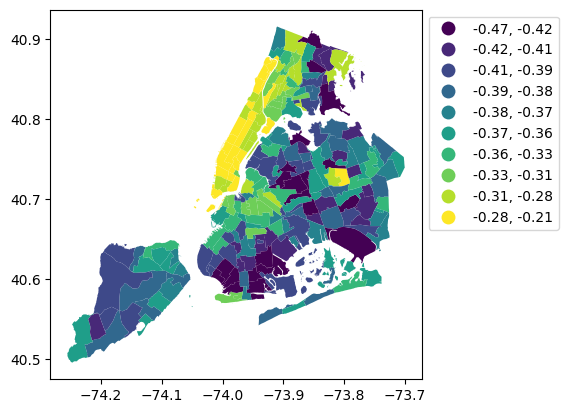

In [82]:
nta_score_geo.plot(column = 'weighted_avg', k=10, scheme='Quantiles',legend=True
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})

In [83]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
nta_score_geo['severity_norm'] = min_max_scaler.fit_transform(np.asarray(nta_score_geo['weighted_avg']).reshape(-1, 1))
nta_score_geo.head()

,boro_code,boro_name,county_fips,ntacode,ntaname,shape_leng,shape_area,geometry,weighted_avg,severity_norm
0,4,Queens,081,QN08,St. Albans,45401.316803,77412747.847,"MULTIPOLYGON (((-73.75205 40.70523, -73.75174 ...",-0.413611,0.217316
1,2,Bronx,005,BX28,Van Cortlandt Village,21945.719299,25666124.5948,"MULTIPOLYGON (((-73.88705 40.88435, -73.88705 ...",-0.342705,0.491726
2,4,Queens,081,QN55,South Ozone Park,36708.1693055,82461393.7368,"MULTIPOLYGON (((-73.80577 40.68293, -73.80552 ...",-0.381688,0.340861
3,3,Brooklyn,047,BK40,Windsor Terrace,19033.6720656,14041667.99,"MULTIPOLYGON (((-73.98017 40.66115, -73.98021 ...",-0.380132,0.346879
4,3,Brooklyn,047,BK50,Canarsie,43703.6096661,82089678.6389,"MULTIPOLYGON (((-73.88834 40.64671, -73.88835 ...",-0.418021,0.200248


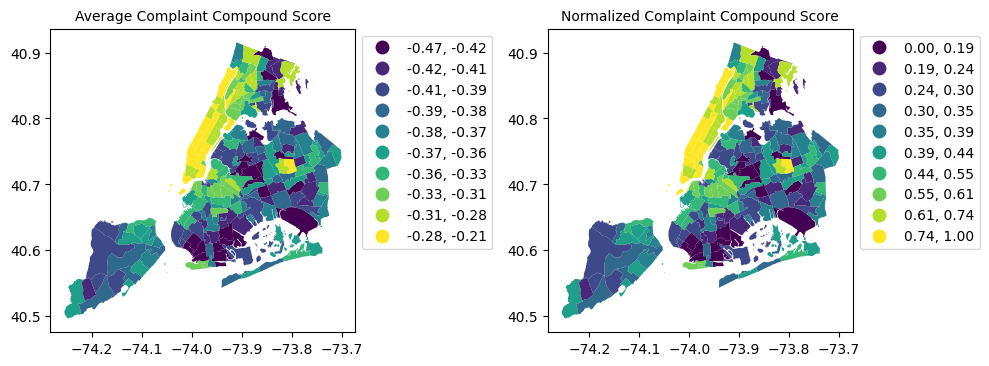

In [85]:
fig,ax = plt.subplots(1,2,figsize = (10,10))
nta_score_geo.plot(column = 'weighted_avg',ax = ax[0], k=10, scheme='Quantiles',legend=True
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
nta_score_geo.plot(column = 'severity_norm',ax = ax[1], k=10, scheme='Quantiles',legend=True
             ,legend_kwds={'bbox_to_anchor': (1, 1),'loc': 'upper left'})
ax[0].set_title('Average Complaint Compound Score',fontsize = 10)
ax[1].set_title('Normalized Complaint Compound Score',fontsize = 10)
fig.tight_layout()

plt.show()

In [87]:
nta_score_final = nta_score_geo[['ntacode','weighted_avg','severity_norm']]
nta_score_final = nta_score_final.rename(columns = {'weighted_avg':'avg_compound_score','severity_norm':'norm_compound_score'})
nta_score_final.head()

,ntacode,avg_compound_score,norm_compound_score
0,QN08,-0.413611,0.217316
1,BX28,-0.342705,0.491726
2,QN55,-0.381688,0.340861
3,BK40,-0.380132,0.346879
4,BK50,-0.418021,0.200248


In [88]:
nta_score_final.to_csv('../Data/nta_complaint_severity_2019.csv')